In [368]:
#Import library
from palmerpenguins import load_penguins
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from io import StringIO
from sklearn.metrics import classification_report, confusion_matrix

In [369]:
#function
def plot_class_distribution(labels, title, ax):
    sns.countplot(x=labels, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")
    
def trainData(X, Y, size_test):
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y,
        test_size=size_test,
        random_state=1,
        shuffle=True,
        stratify=Y
    )
    Y_train = Y_train.idxmax(axis=1).apply(lambda x: x.replace('species_', ''))
    Y_test = Y_test.idxmax(axis=1).apply(lambda x: x.replace('species_', ''))

    clf = DecisionTreeClassifier(criterion='entropy')
    clf = clf.fit(X_train, Y_train)
    Y_predict = clf.predict(X_test)
    return X_train, X_test, Y_train, Y_test, clf, Y_predict

def visualizeDataset(Y_original, Y_train, Y_test, size_train, size_test):
    figure, axes = plt.subplots(1, 3, figsize=(18, 5))
    plot_class_distribution(Y_original, "Original Dataset", axes[0])
    plot_class_distribution(Y_train, f"Training Set ({size_train}%)", axes[1])
    plot_class_distribution(Y_test, f"Test Set ({size_test}%)", axes[2])

    print(f"Visualize dataset {size_train}/{size_test}")
    plt.tight_layout()
    plt.show()

def buildTree(clf, X_train, class_names):
    dot_data = StringIO()
    export_graphviz(clf, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True,
                    feature_names=X_train.columns,
                    class_names=class_names['species'])
    return dot_data
    
    
def drawTree(dot_data, size_train, size_test):
    print(f"Decision tree with dataset {size_train}/{size_test}")
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    display(Image(graph.create_png()))  # hiển thị trực tiếp trong notebook    
    
def drawTreeWithDepth(dot_data, depth):
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    print(f"Decision Tree (max_depth={depth})")
    display(Image(graph.create_png()))  # hiển thị đúng trong notebook
    
def classificationReport(Y_test, Y_predict, size_train, size_test):
    print(f"Classification Report ({size_train}/{size_test}):\n")
    print(classification_report(Y_test, Y_predict))
    
def confusionMatrixReport(Y_test, Y_predict, clf, size_train, size_test):
    print(f"Confusion Matrix (Depth={clf.tree_.max_depth}, {size_train}/{size_test} split):\n")
    cm = confusion_matrix(Y_test, Y_predict)
    # Plotting confusion matrix as a heatmap for better visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
def accuraciesReport(accuracies, max_depth):
    results = pd.DataFrame({
        'max_depth': ['None'] + max_depth[1:],
        'Accuracy': accuracies
    })
    results = results.set_index("max_depth").T
    print(results.to_string())
def chartReport(accuracies):
    # Vẽ biểu đồ
    plt.figure(figsize=(8, 6))
    plt.plot(['None', 2, 3, 4, 5, 6, 7], accuracies, marker='o')

    # Hiển thị giá trị độ chính xác tại các điểm
    for i, acc in enumerate(accuracies):
        plt.text(i, acc, f'{acc:.2f}', ha='center', va='bottom')

    plt.title('Decision Tree Accuracy vs Max Depth')
    plt.xlabel('Max Depth')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

In [370]:
#preprocessing data
penguins = load_penguins()
class_names = {}

for col in penguins.columns:
    if penguins[col].dtype == 'object':
        # Lưu lại tên các nhãn cho từng cột dạng chuỗi
        class_names[col] = penguins[col].unique().tolist()

# One-hot encoding cho tất cả các cột dạng object
penguins_encoded = pd.get_dummies(penguins, dummy_na=True)
feature = [col for col in penguins_encoded.columns if not col.startswith('species_')]
species = [col for col in penguins_encoded.columns if col.startswith('species_')]
X = penguins_encoded[feature]
Y = penguins_encoded[species]
Y_original = Y.idxmax(axis=1).apply(lambda x: x.replace('species_', ''))

In [371]:
# #Train data 40/60
X_train_40_60, X_test_40_60, Y_train_40_60, Y_test_40_60, clf_40_60, Y_predict_40_60 = trainData(X, Y, 0.6)

Visualize dataset 40/60


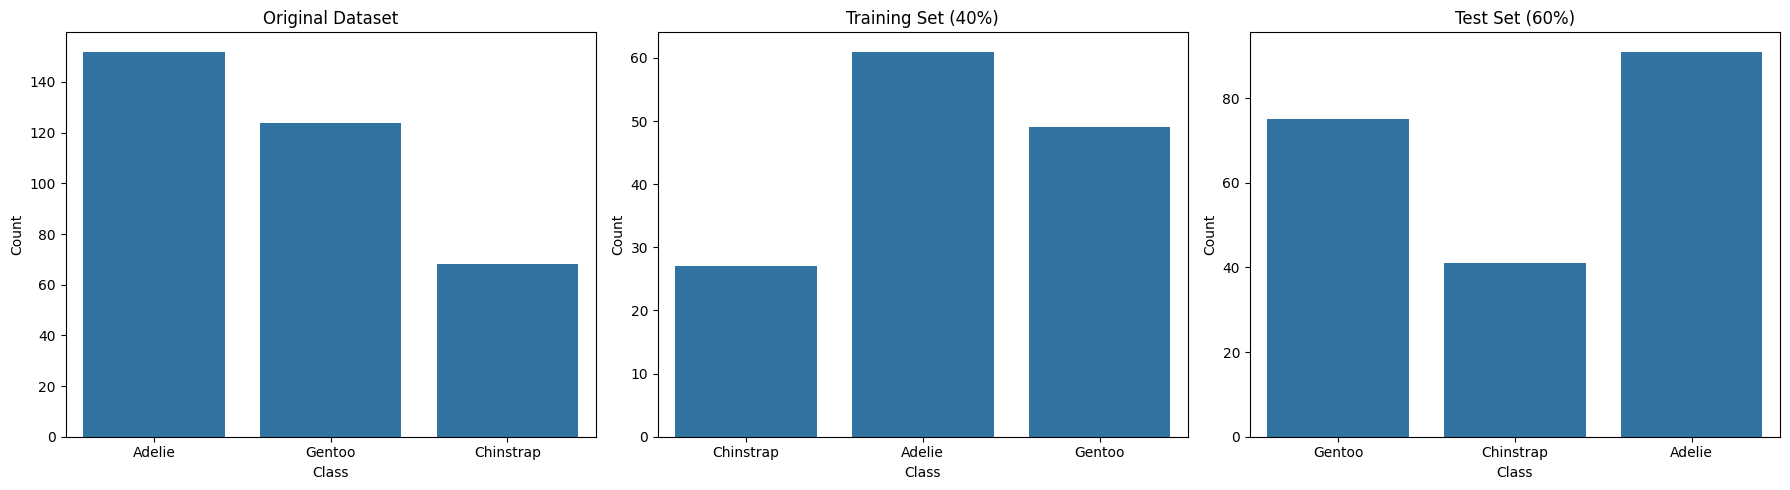

In [372]:
# # Visualize dataset 40/60
visualizeDataset(Y_original, Y_train_40_60, Y_test_40_60, 40, 60)

In [373]:
# # train data 60/40
X_train_60_40, X_test_60_40, Y_train_60_40, Y_test_60_40, clf_60_40, Y_predict_60_40 = trainData(X, Y, 0.4)

Visualize dataset 60/40


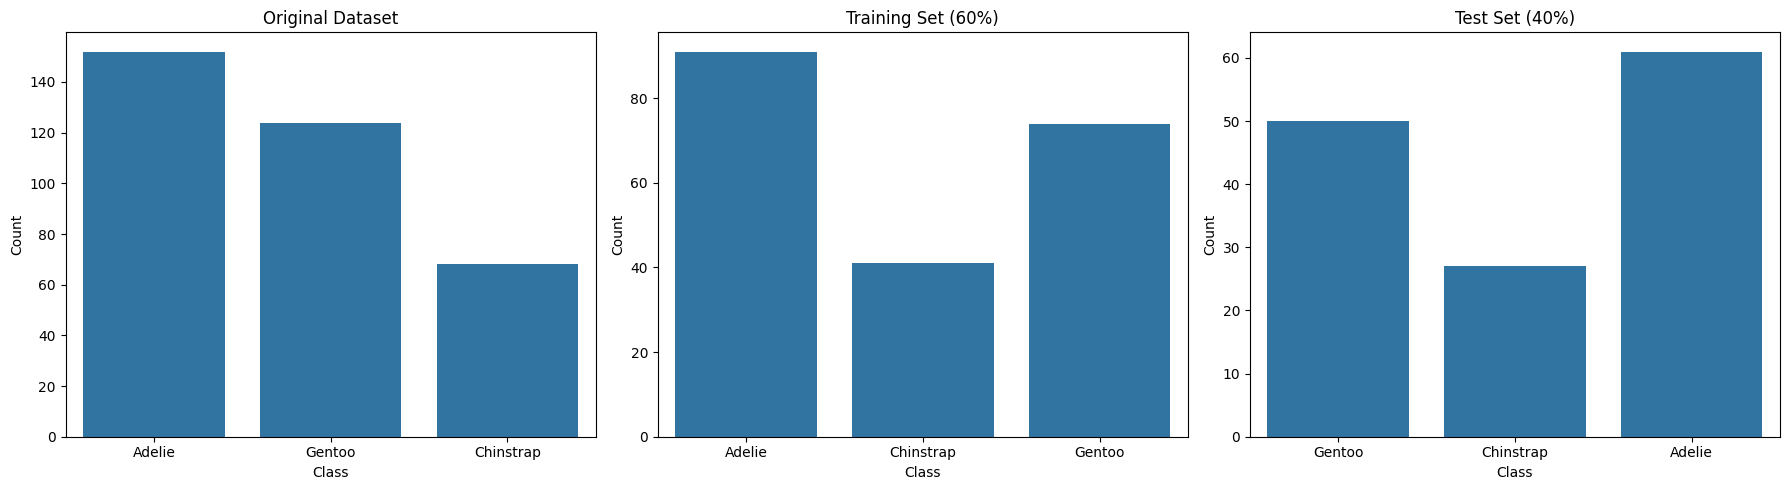

In [374]:
# Visualize dataset 60/40
visualizeDataset(Y_original, Y_train_60_40, Y_test_60_40, 60, 40)

In [375]:
# Train data 80/20
X_train_80_20, X_test_80_20, Y_train_80_20, Y_test_80_20, clf_80_20, Y_predict_80_20 = trainData(X, Y, 0.2)

Visualize dataset 80/20


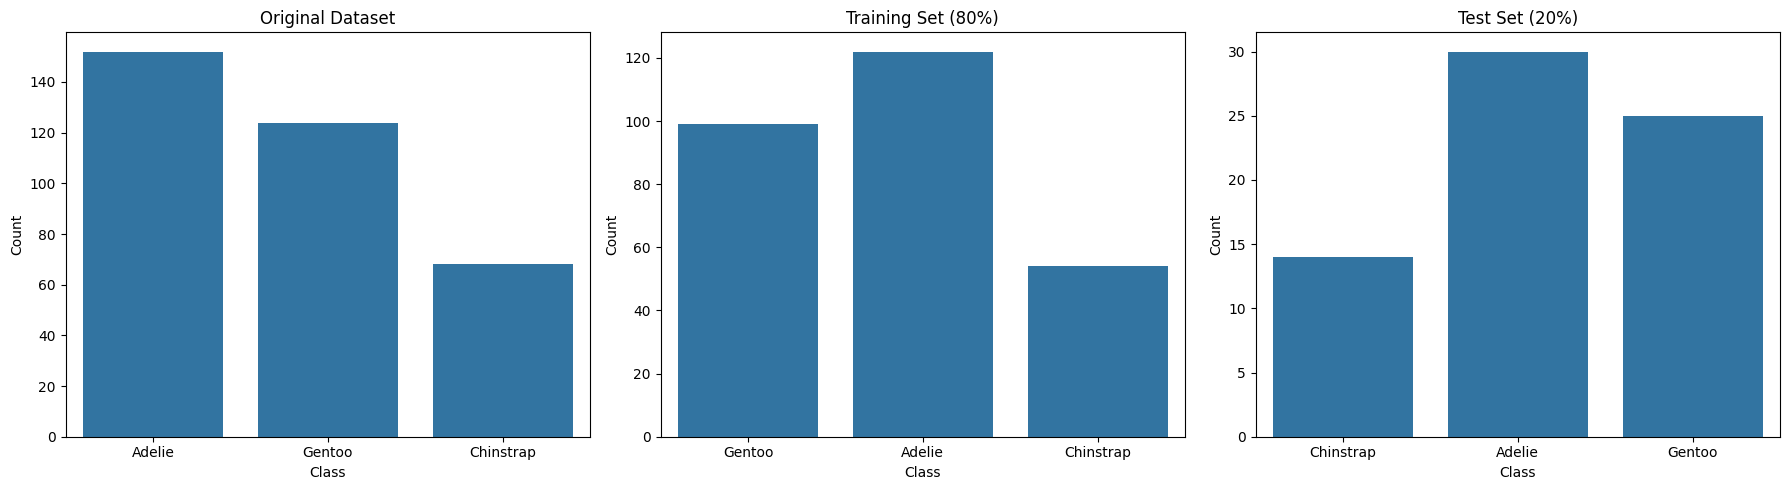

In [376]:
# Visualize dataset 80/20
visualizeDataset(Y_original, Y_train_80_20, Y_test_80_20, 80, 20)


In [377]:
# Train data 90/10
X_train_90_10, X_test_90_10, Y_train_90_10, Y_test_90_10, clf_90_10, Y_predict_90_10 = trainData(X, Y, 0.1)

Visualize dataset 90/10


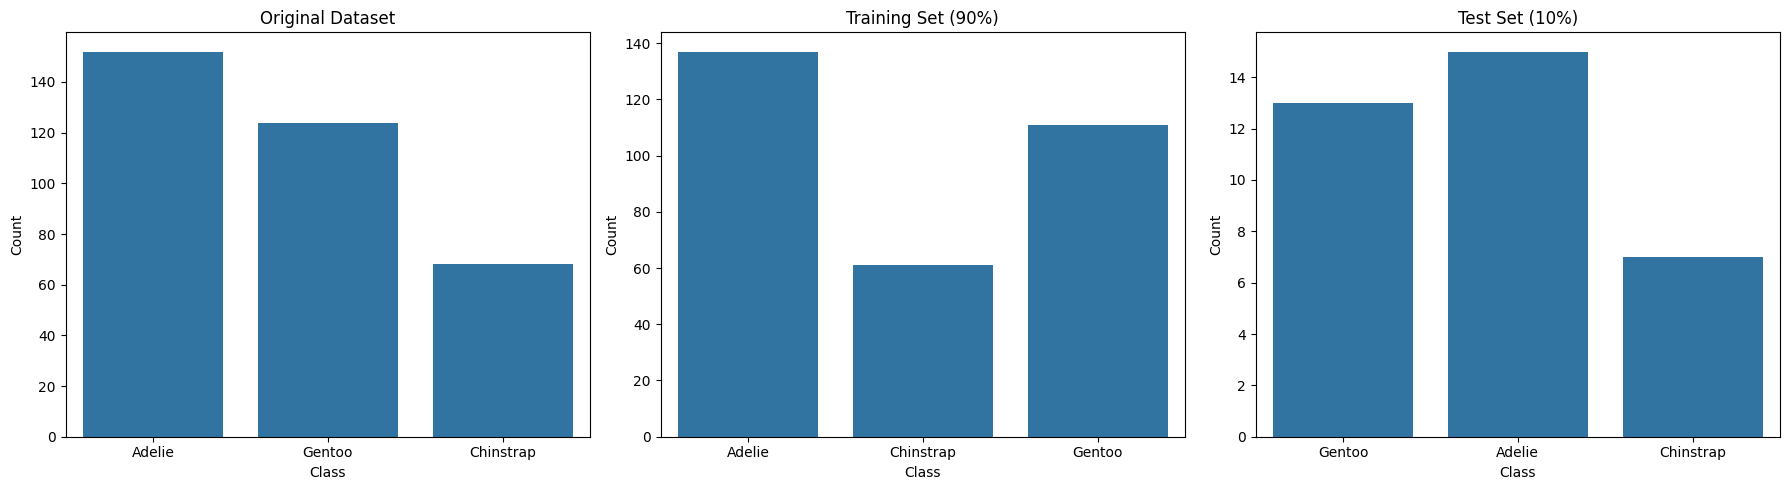

In [378]:
# Visualize dataset 90/10
visualizeDataset(Y_original, Y_train_90_10, Y_test_90_10, 90, 10)


Decision tree with dataset 40/60


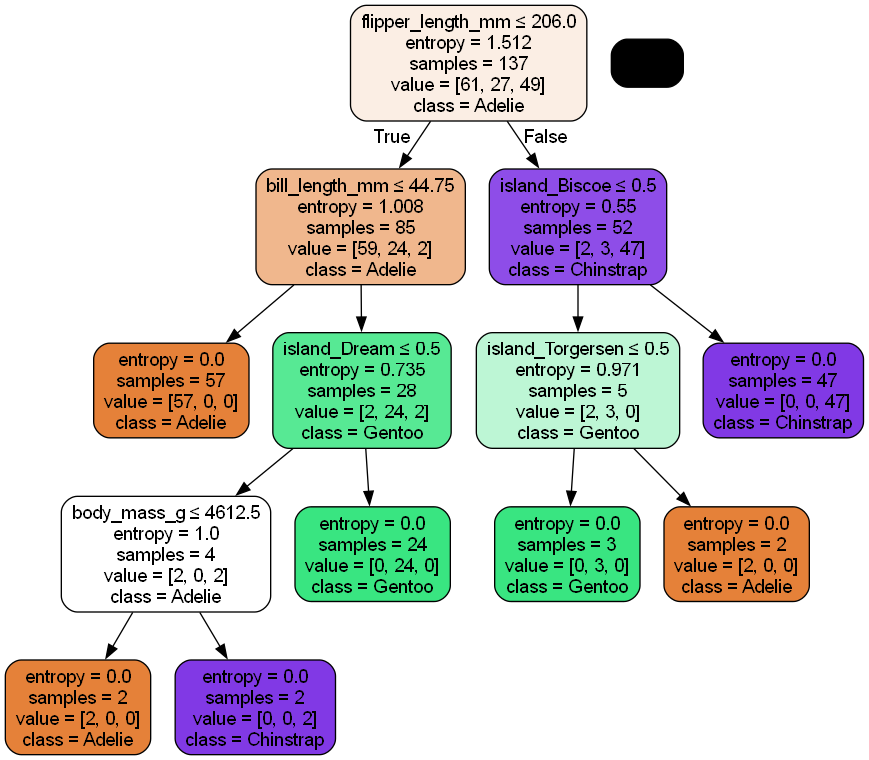

In [379]:
#Decision tree 40/60
dot_data = buildTree(clf_40_60, X_train_40_60, class_names)
drawTree(dot_data, 40, 60)

In [380]:
classificationReport(Y_test_40_60, Y_predict_40_60, 40, 60)

Classification Report (40/60):

              precision    recall  f1-score   support

      Adelie       0.93      0.99      0.96        91
   Chinstrap       0.97      0.85      0.91        41
      Gentoo       1.00      0.99      0.99        75

    accuracy                           0.96       207
   macro avg       0.97      0.94      0.95       207
weighted avg       0.96      0.96      0.96       207



Confusion Matrix (Depth=4, 40/60 split):



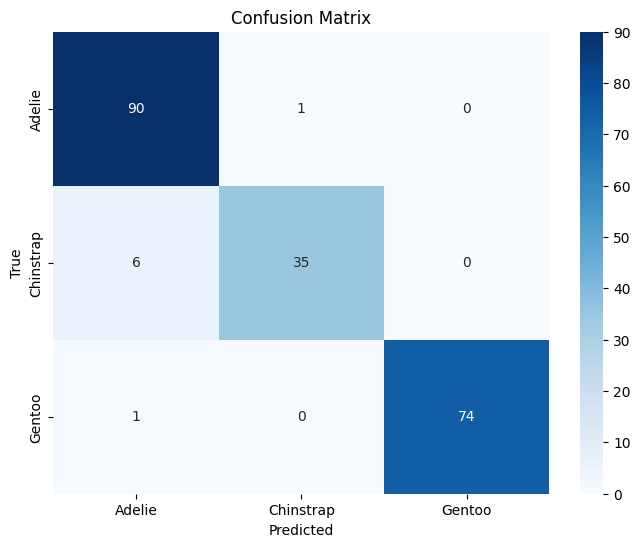

In [381]:
confusionMatrixReport(Y_test_40_60, Y_predict_40_60, clf_40_60, 40, 60)

Decision tree with dataset 60/40


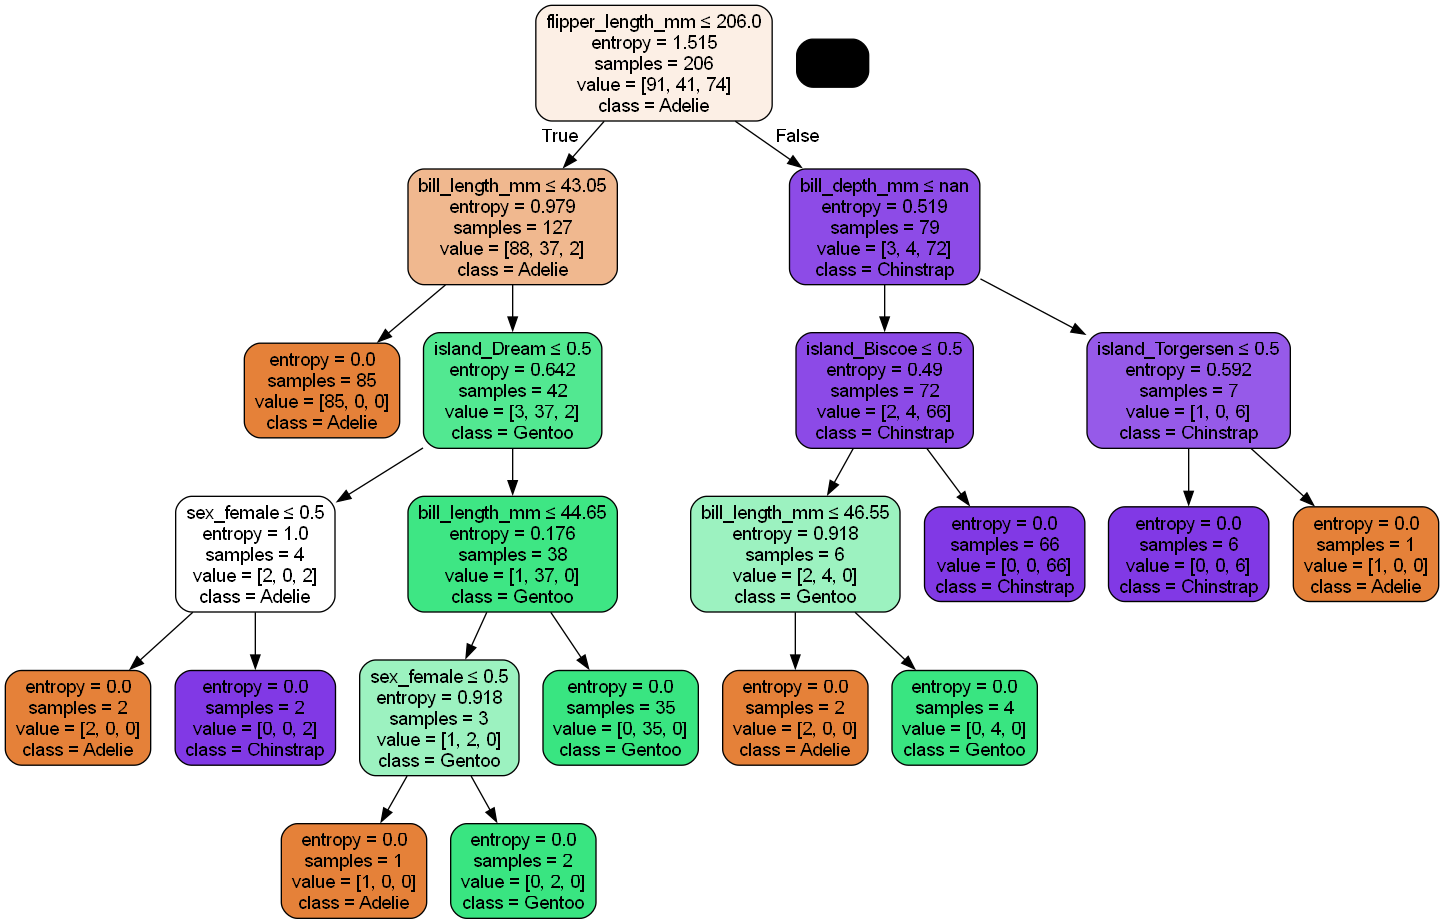

In [382]:
#Decision tree 60/40
dot_data = buildTree(clf_60_40, X_train_60_40, class_names)
drawTree(dot_data, 60, 40)

In [383]:
classificationReport(Y_test_60_40, Y_predict_60_40, 60, 40)

Classification Report (60/40):

              precision    recall  f1-score   support

      Adelie       0.92      1.00      0.96        61
   Chinstrap       1.00      0.81      0.90        27
      Gentoo       0.98      0.98      0.98        50

    accuracy                           0.96       138
   macro avg       0.97      0.93      0.95       138
weighted avg       0.96      0.96      0.96       138



Confusion Matrix (Depth=5, 60/40 split):



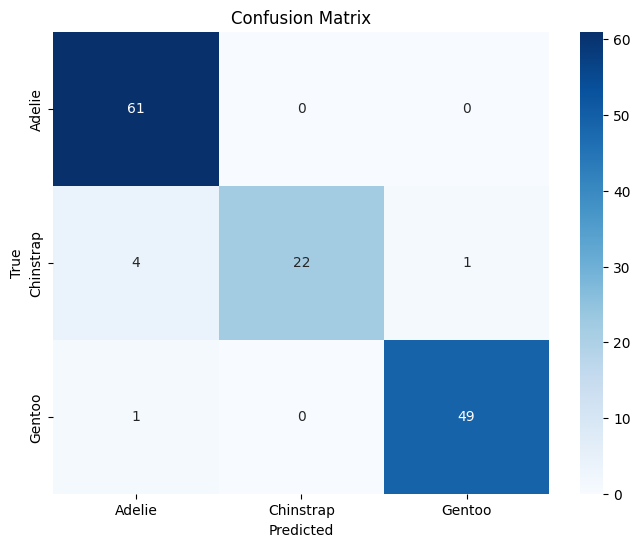

In [384]:
confusionMatrixReport(Y_test_60_40, Y_predict_60_40, clf_60_40, 60, 40)

Decision tree with dataset 80/20


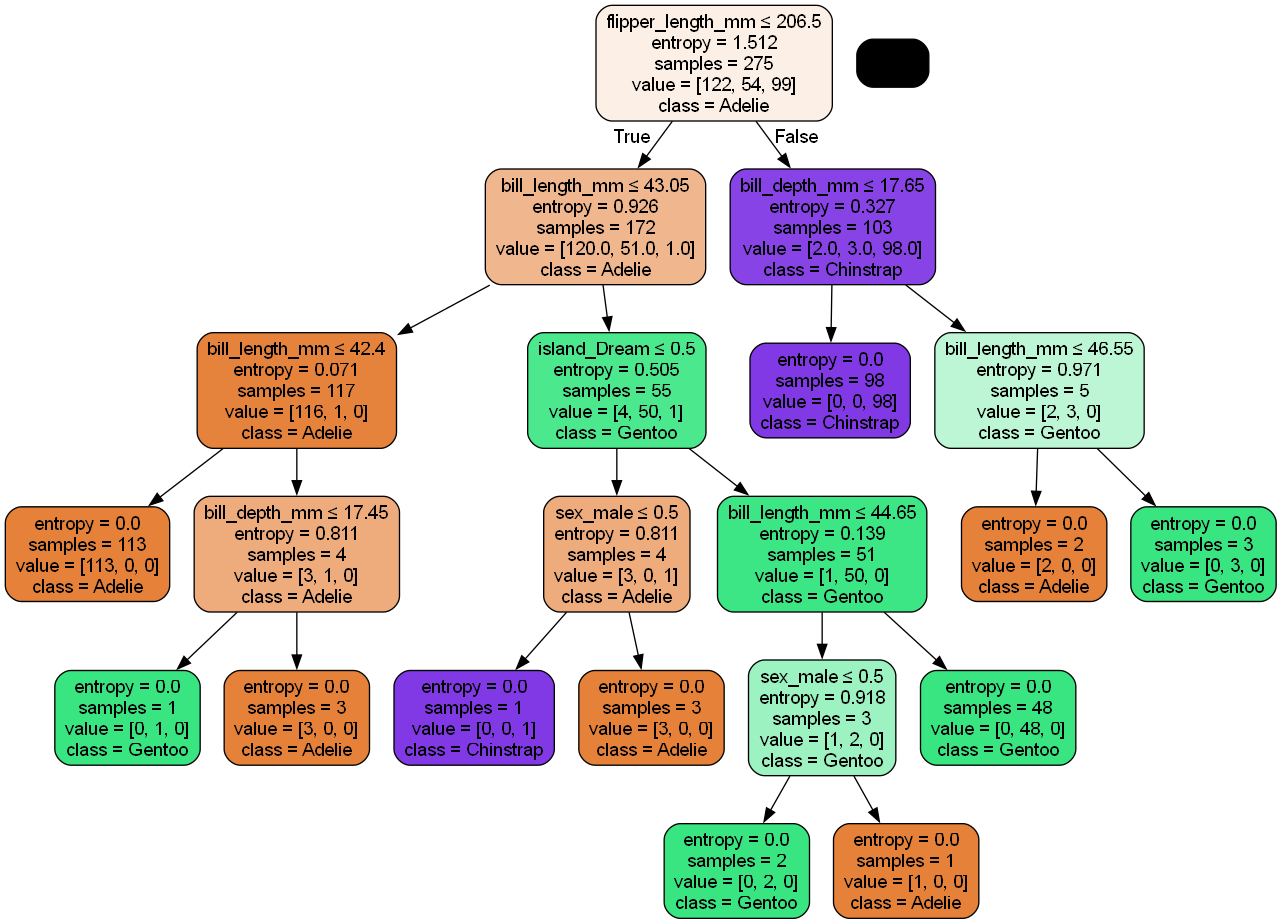

In [385]:
#Decision tree 80/20
dot_data = buildTree(clf_80_20, X_train_80_20, class_names)
drawTree(dot_data, 80, 20)

In [386]:
classificationReport(Y_test_80_20, Y_predict_80_20, 80, 20)

Classification Report (80/20):

              precision    recall  f1-score   support

      Adelie       0.97      1.00      0.98        30
   Chinstrap       1.00      0.93      0.96        14
      Gentoo       1.00      1.00      1.00        25

    accuracy                           0.99        69
   macro avg       0.99      0.98      0.98        69
weighted avg       0.99      0.99      0.99        69



Confusion Matrix (Depth=5, 80/20 split):



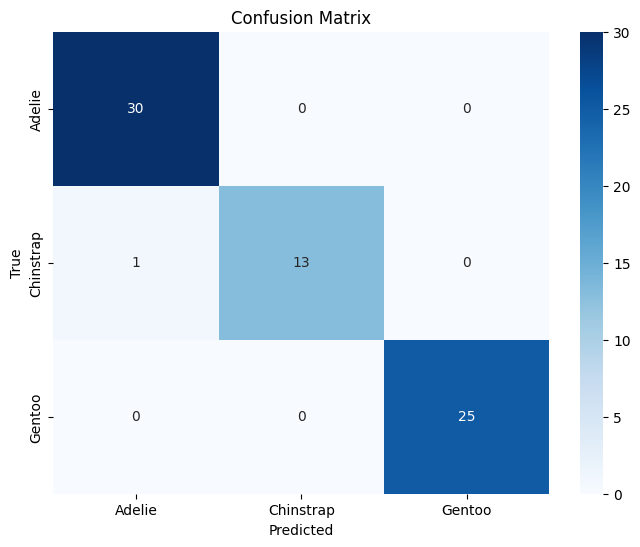

In [387]:
confusionMatrixReport(Y_test_80_20, Y_predict_80_20, clf_80_20, 80, 20)

Decision tree with dataset 90/10


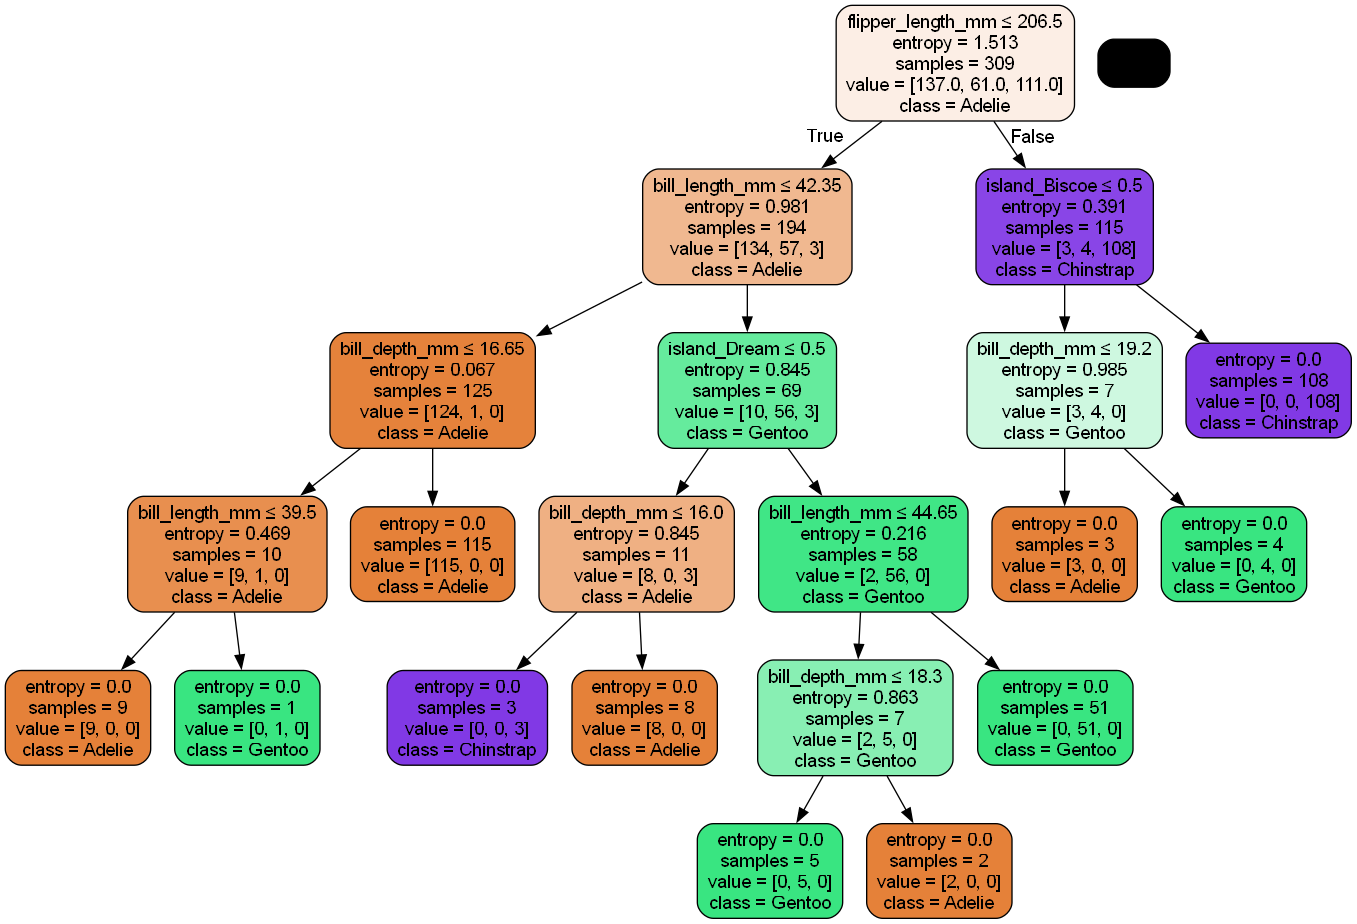

In [388]:
#Decision tree 90/10
dot_data = buildTree(clf_90_10, X_train_90_10, class_names)
drawTree(dot_data, 90, 10)

In [389]:
classificationReport(Y_test_90_10, Y_predict_90_10, 90, 10)

Classification Report (90/10):

              precision    recall  f1-score   support

      Adelie       0.94      1.00      0.97        15
   Chinstrap       1.00      0.86      0.92         7
      Gentoo       1.00      1.00      1.00        13

    accuracy                           0.97        35
   macro avg       0.98      0.95      0.96        35
weighted avg       0.97      0.97      0.97        35



Confusion Matrix (Depth=5, 90/10 split):



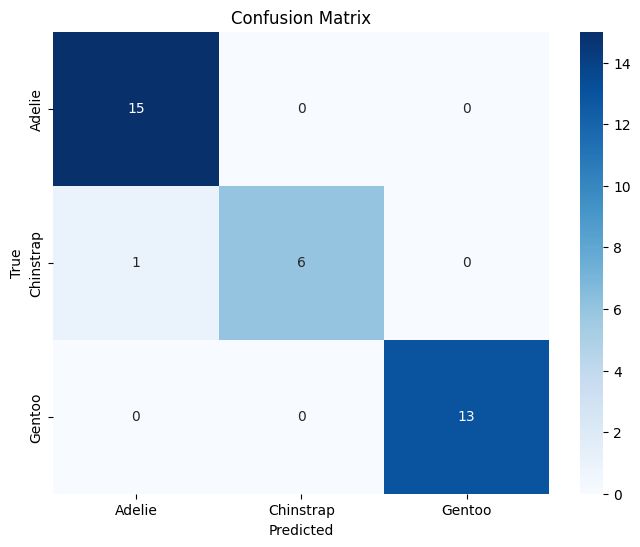

In [390]:
confusionMatrixReport(Y_test_90_10, Y_predict_90_10, clf_90_10, 90, 10)

In [391]:
#Prepare dataset 80/20 for each depth
max_depth = [None, 2, 3, 4, 5, 6, 7]
accuracies = []
trees = {}

for depth in max_depth:
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=depth, random_state=1)
    clf.fit(X_train_80_20, Y_train_80_20)
    Y_predict = clf.predict(X_test_80_20)
    accuracies.append(metrics.accuracy_score(Y_test_80_20, Y_predict))
    trees[depth] = clf

Decision Tree (max_depth=None)


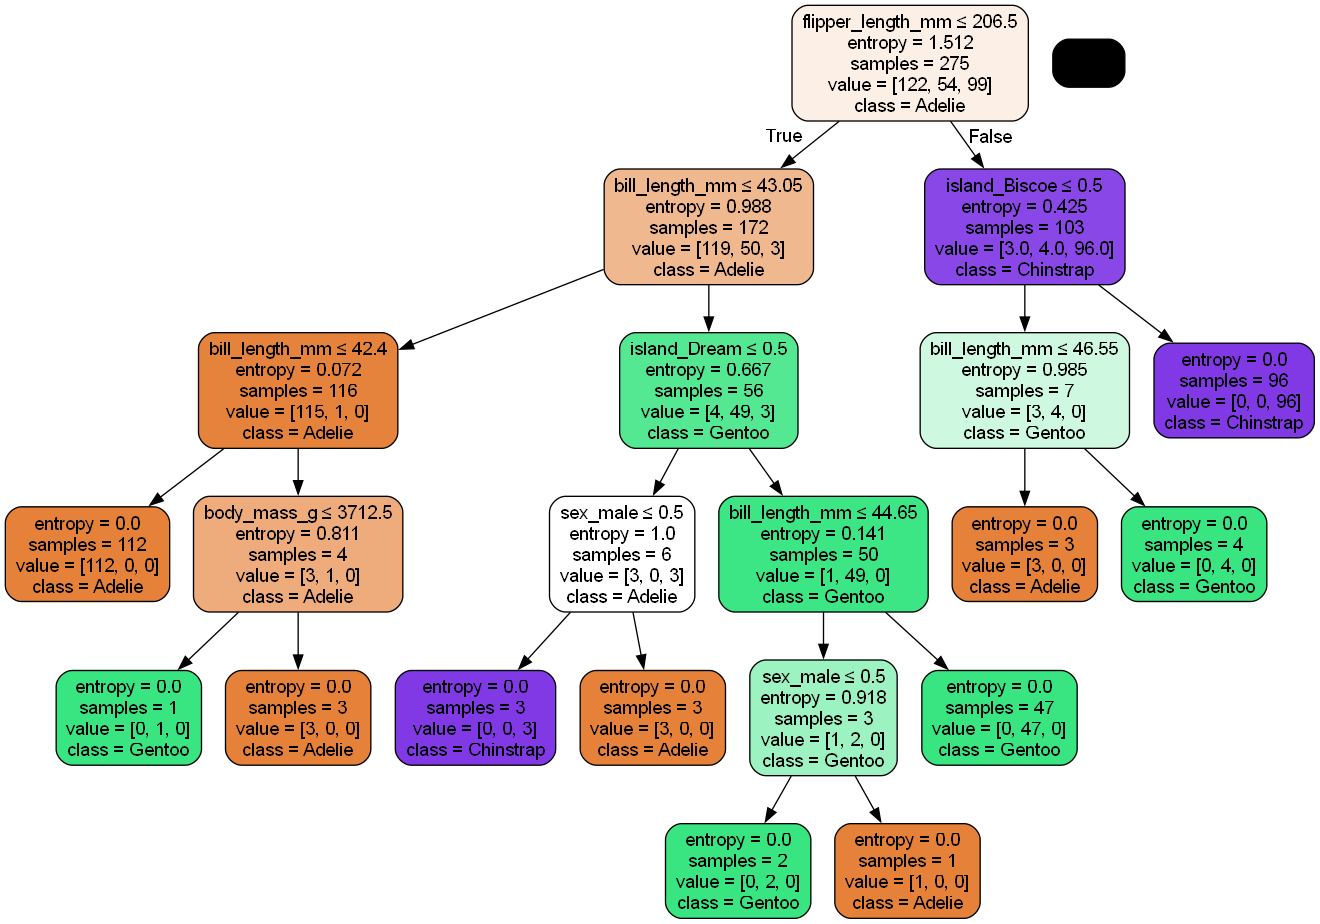

Decision Tree (max_depth=2)


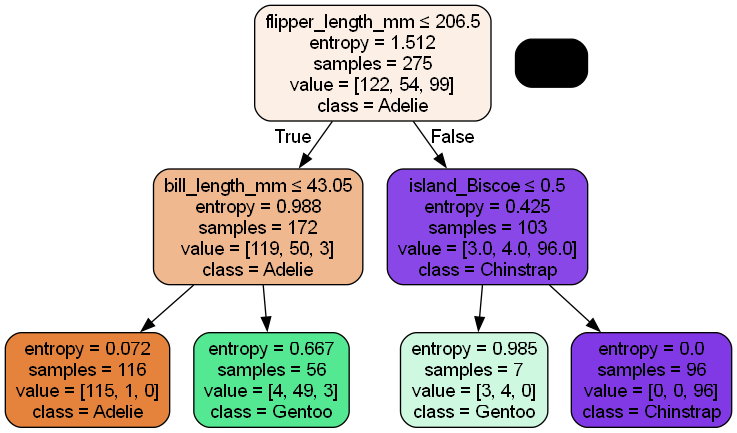

Decision Tree (max_depth=3)


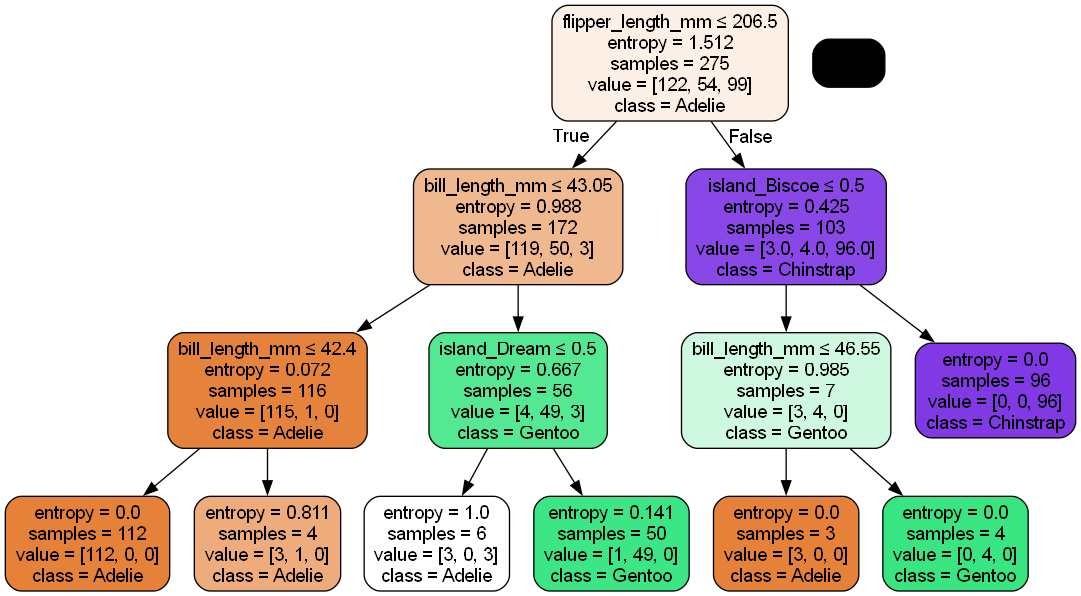

Decision Tree (max_depth=4)


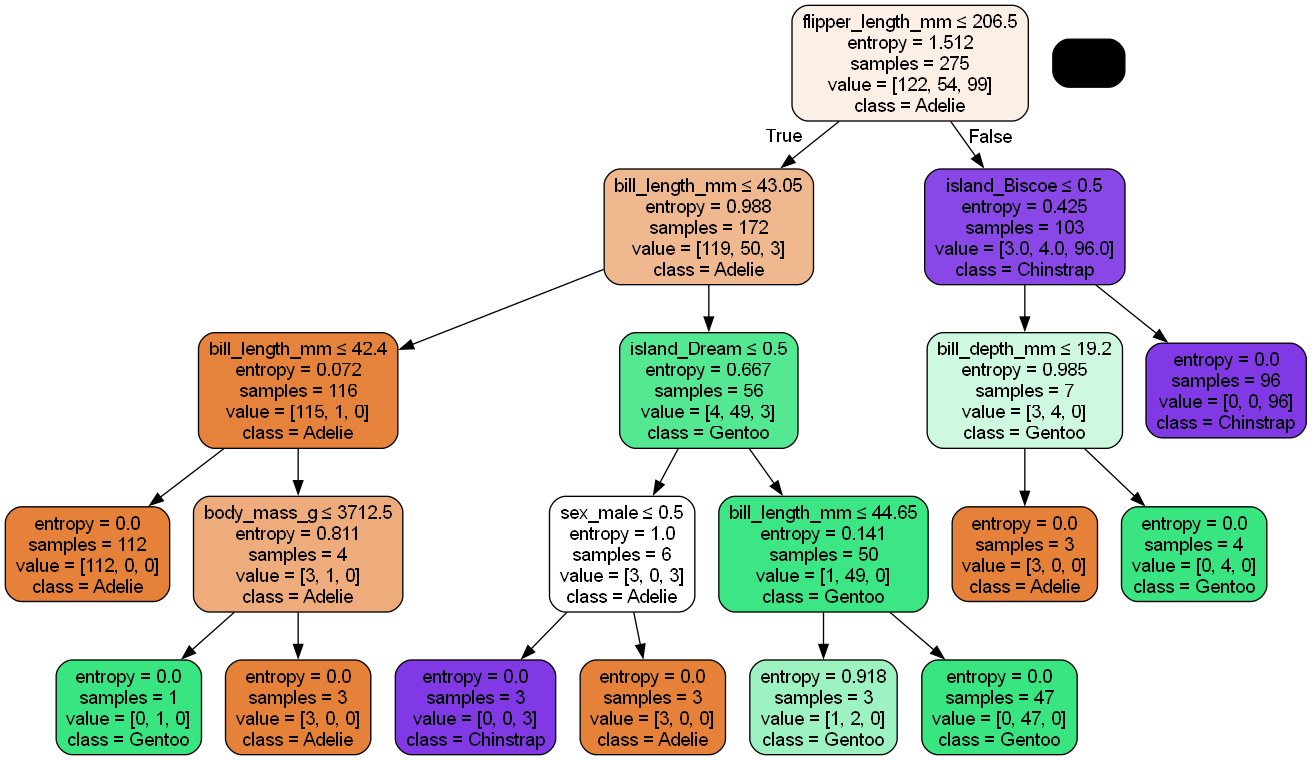

Decision Tree (max_depth=5)


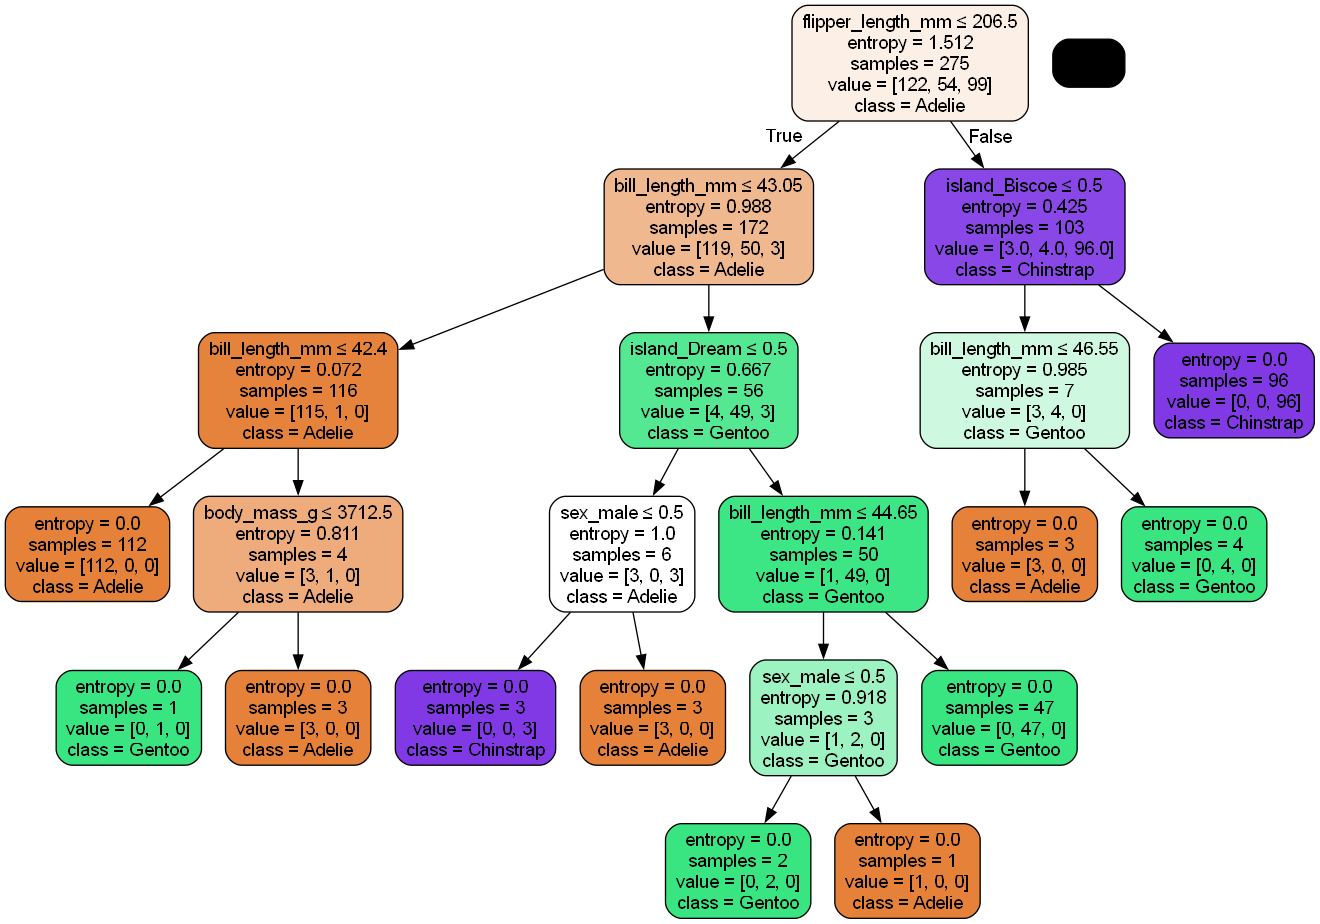

Decision Tree (max_depth=6)


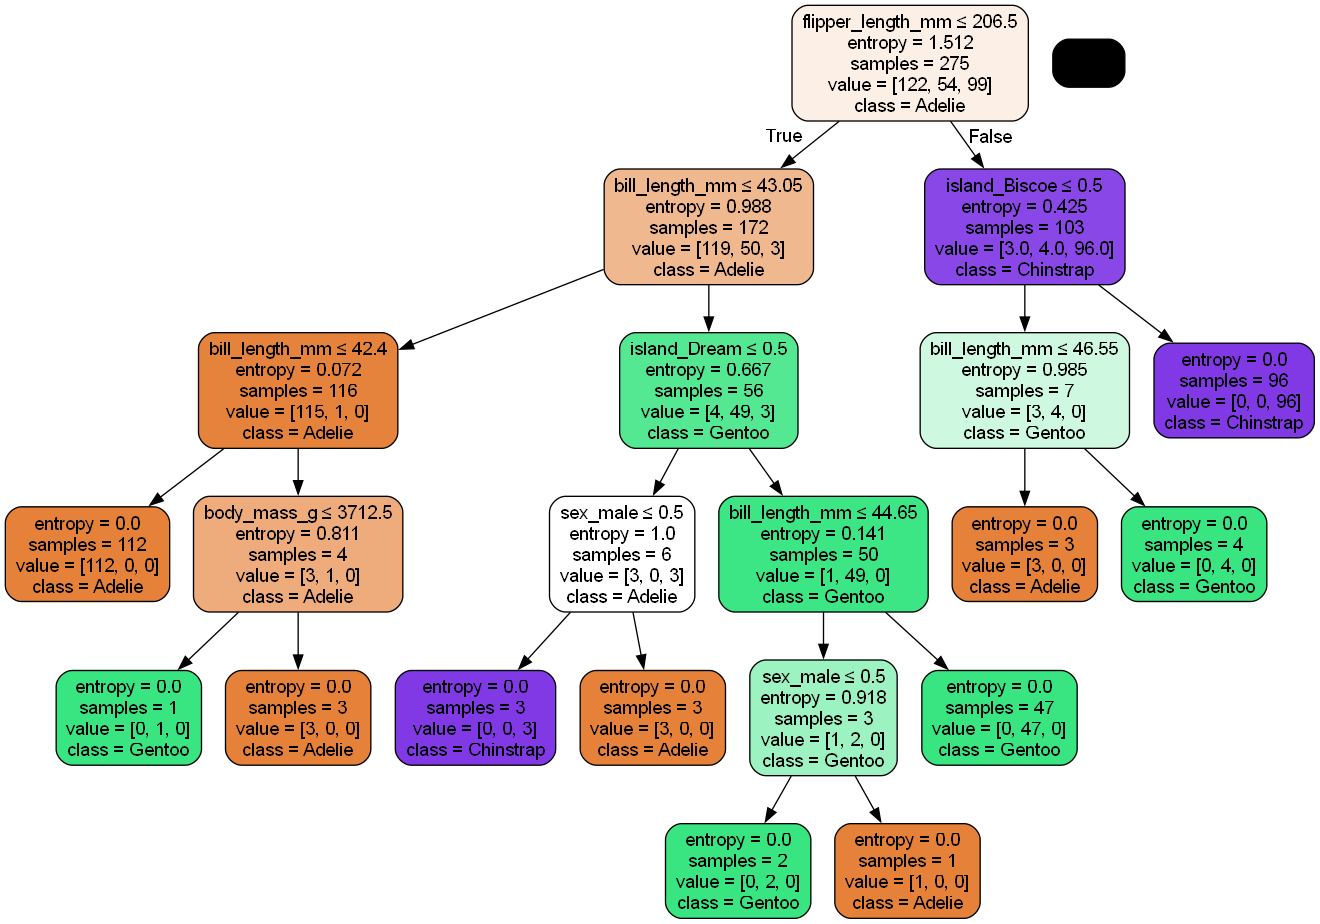

Decision Tree (max_depth=7)


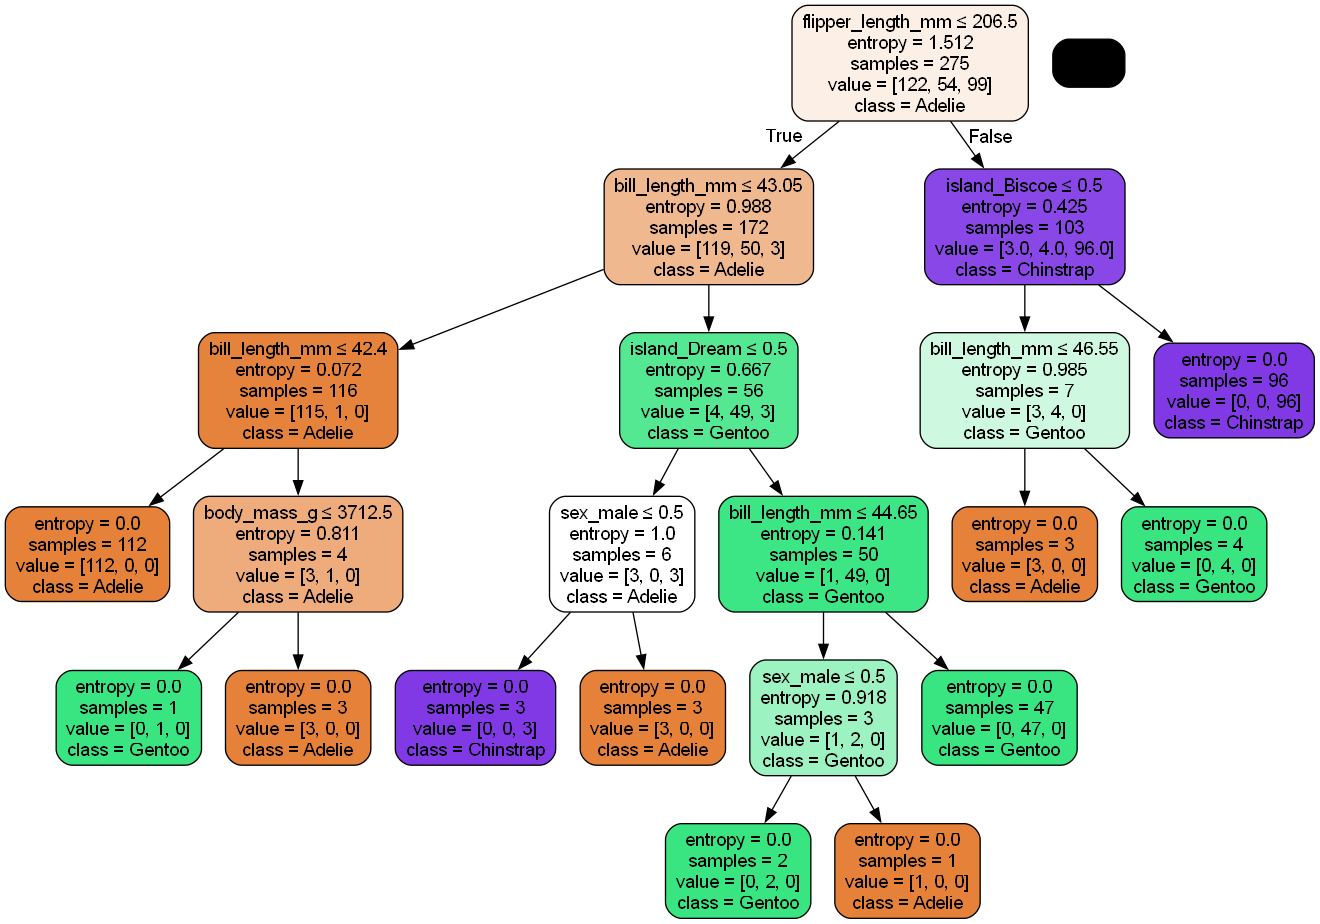

In [392]:
#Decision tree 80/20
for depth in max_depth:
    dot_data = buildTree(trees[depth], X_train_80_20, class_names)
    drawTreeWithDepth(dot_data, depth)


In [393]:
accuraciesReport(accuracies, max_depth)

max_depth      None         2         3         4         5         6         7
Accuracy   0.985507  0.913043  0.942029  0.956522  0.985507  0.985507  0.985507


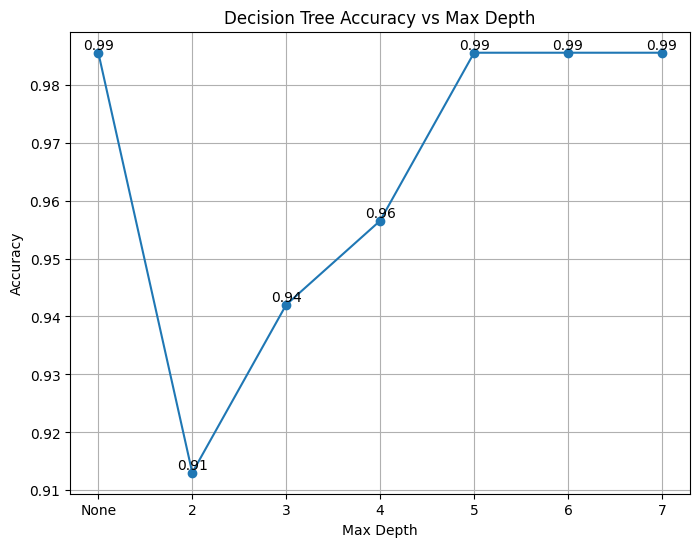

In [394]:
chartReport(accuracies)